### Identify causal terms according to closest opposite match
- Get closest opposite match for each top term
- Find a threshold to distinguish between causal and non-causal

In [1]:
import io, time
from itertools import combinations, cycle, product
from IPython.display import display

import nltk
import numpy as np
import pandas as pd
import pickle, random, re
from collections import Counter
from PyDictionary import PyDictionary
dictionary=PyDictionary()

from tqdm.notebook import tqdm
pd.set_option('max_colwidth', -1)

import sklearn

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import roc_auc_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import classification_report, accuracy_score

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

random.seed(42)

In [21]:
data_path = 'my_data_path'

In [3]:
class SentenceEdit:
    def __init__(self, remove_wd, sentence_idx, left_context, right_context, context, label):
        
        self.sentence_idx = sentence_idx
        self.remove_wd = remove_wd
        self.context = context
        self.label = label
        self.left_context = left_context
        self.right_context = right_context
        
      
    def __repr__(self):
        " returns a printable string representation of an object"
        if(len(str(self.left_context).strip() + str(self.right_context).strip())==0):
            return '%s ||| %s \n' % (str(self.context), str(self.label))
        else:
            return '%s ||| %s ||| %s ||| %s \n' % (str(self.remove_wd), str(self.left_context), str(self.right_context), str(self.label))
    
class Counterfactual:
    def __init__(self, df_train, df_test, moniker):
        display(df_train.head(1))
        self.moniker = moniker
        self.train = df_train
        self.test = df_test

In [4]:
def get_closest_match(df_ite_match):
    """
    Get closest opposite match and similarity between matched sentences
    """
    closest_match = []
    for ri, row in df_ite_match.iterrows():
        sentence_label = row.sentence.label
        match_id = -1
        similarity = 0.0
        for match, sim in row['treat_match']:
            if(match.label + sentence_label == 0):
                match_id = match.sentence_idx
                similarity = sim
                break
        if(match_id != -1): 
            closest_match.append({'term':row.term,'sentence_id':row.sentence.sentence_idx,'label':sentence_label,
                                  'match_id':match_id,'match_label':match.label,'similarity':sim})
    
    return pd.DataFrame(closest_match)

In [6]:
def get_causal_label(df_close_match,df_vocab,aggregate):
    """
    True causal label for each top term (read from pre-annotated file) 
    """
    causal_terms = []
    for term, df_term in df_close_match.groupby('term'):
        if(aggregate == 'max'):
            max_sim = max(df_term.similarity)
            match_row = df_term[df_term.similarity == max_sim]
        elif(aggregate == 'mean'):
            max_sim = np.mean(df_term.similarity)
            
        if(term in df_vocab.term.values):
            causal = df_vocab[df_vocab.term == term].causal.values[0]
        else:
            causal = -1
        causal_terms.append({'term': term, 'similarity': max_sim, 'causal': causal}) 
    
    return pd.DataFrame(causal_terms)

In [20]:
def get_term_coef(df_term, moniker):
    """
    Word coefficient from original classifier
    """
    # get original training data
    if (moniker == 'IMDb'):
        ds_imdb = pickle.load(open(data_path+"ds_imdb.pkl", "rb"))
        df = ds_imdb.train[['text','label']]
        df.reset_index(drop=True,inplace=True)
    elif(moniker == 'Kindle'):
        df_kindle = pickle.load(open(data_path+"kindle_data.pkl",'rb'))
        df = df_kindle[df_kindle['flag']=='selected_train']
        df.reset_index(drop=True,inplace=True)
    
    # fit classifier
    vec = CountVectorizer(min_df=5, binary=True, max_df=.8)
    X_train = vec.fit_transform(df.text.values)
    clf = LogisticRegression(class_weight='auto', solver='lbfgs', max_iter=1000)
    clf.fit(X_train, df.label.values)
    
    # get feature coef
    df_term['coef'] = df_term.term.apply(lambda x: clf.coef_[0][vec.vocabulary_[x]])
    

In [7]:
def show_result(df_causal, moniker, sort_by):
    """
    Fig 1: correlation between word coef and word closest opposite match
           - each point represents a word
           - x-axis: similarity score of a word's closest opposite match
           - y-axis: word's coefficient from original classifier
    Fig 2: Precision and recall according to different thresholds
    """
    fig, axs = plt.subplots(nrows=1,ncols=2, figsize=(16,8), sharex=True)
    fig.text(0.5, 0.02, 'Similarity score of closest opposite match',va='bottom', ha='center', fontsize=30)

    # plot (coef, closest opposite match), sort values by coef 
    if(sort_by == 'coef'):
        axs[0].set_ylabel('Term coefficient (abs)', fontsize=28)
        
        df_causal['abs_coef'] = df_causal['coef'].apply(lambda x: abs(x))
        df_causal_sorted = df_causal.sort_values(by=['abs_coef'])
        
        for causal, m, c, lb in zip([1,0],['o','X'],['purple','olive'],['causal','non-causal']):
            axs[0].plot([float('%.2f' % s) for s in df_causal_sorted[df_causal_sorted.causal == causal].similarity.values[:-1]], 
                        [float('%.2f' % c) for c in df_causal_sorted[df_causal_sorted.causal == causal].abs_coef.values[:-1]], 
                        alpha=0.7, marker=m, markersize=13,linestyle='',color=c, label=lb)
        
        axs[0].axvline(x=0.95, linestyle='--', color='green')
        axs[0].tick_params(axis='x', labelsize=28)
        axs[0].tick_params(axis='y', labelsize=28)
        axs[0].set_yticks(np.arange(1,2.6,0.5))
        axs[0].set_yticklabels(np.arange(1,2.6,0.5))
        lgnd = axs[0].legend(loc='upper left', fontsize=23, borderpad=0.1)
        
        lgnd.legendHandles[0]._legmarker.set_markersize(12)
        lgnd.legendHandles[1]._legmarker.set_markersize(12)
                
    elif(sort_by == 'similarity'):
        df_causal_sorted = df_causal.sort_values(by=['similarity'])
        for causal, m in zip([1,0],['o','x']):
            axs[0].plot(df_causal_sorted[df_causal_sorted.causal == causal].similarity.values, marker=m, linestyle='')
    elif(sort_by == 'random'): # not sort
        for causal, m in zip([1,0],['o','X']):
            axs[0].plot(df_causal[df_causal.causal == causal].similarity.values, marker=m, linestyle='')
        
    # plot precision recall curve
    thresh_result = []
    for t in np.arange(0.85, 1.0, 0.01):
        n_select_terms = df_causal[(df_causal.similarity>t) & (df_causal.causal != -1)].shape[0]
        n_causal_terms = df_causal[(df_causal.similarity>t) & (df_causal.causal == 1)].shape[0]
        n_all_causal_terms = df_causal[df_causal.causal == 1].shape[0]
        
        if(n_select_terms > 0):
            thresh_result.append({'similarity_thresh':t, 
                                  'precision':n_causal_terms/n_select_terms, 
                                  'recall':n_causal_terms/n_all_causal_terms})

    df_result = pd.DataFrame(thresh_result)

    axs[1].yaxis.tick_right()
    axs[1].yaxis.set_label_position("right")
    axs[1].tick_params(axis='x', labelsize=28)
    axs[1].tick_params(axis='y', labelsize=28)
    axs[1].axvline(x=0.95, linestyle='--',color='green')

    axs[1].set_ylabel('Evaluation score', fontsize=28)
    axs[1].plot(list(df_result.similarity_thresh.values), list(df_result.precision.values),'o-', label='precision',markersize=13)
    axs[1].plot(list(df_result.similarity_thresh.values), list(df_result.recall.values),'o-', label='recall', marker='P',markersize=13)
    
    axs[1].legend(loc='lower left', fontsize=23, borderpad=0.1)
    
    plt.subplots_adjust(wspace=0.05, hspace=0.2)
    
    fig.tight_layout(rect=[0, 0.1, 1, 0.95])
#     fig.savefig('./Fig/'+moniker+'.png')

In [10]:
def run_experiment(moniker,sort_by='random'):
    """
    run experiments for imdb sentences and kindle sentences
    """
    if(moniker == 'IMDb'):
        df_ite_match = pickle.load(open(data_path+'imdb_ite_match.pkl','rb'))
        df_vocab = pd.read_csv(data_path+'imdb_vocab_antonym_causal.csv')   
    elif(moniker == 'Kindle'):
        df_ite_match = pickle.load(open(data_path+'kindle_ite_match.pkl','rb'))
        df_vocab = pd.read_csv(data_path+'kindle_vocab_antonym_causal.csv')
        
    df_close_match = get_closest_match(df_ite_match)
    df_causal_max = get_causal_label(df_close_match,df_vocab,aggregate = 'max')
    get_term_coef(df_causal_max, moniker)
    
    print("Results for %s" % moniker)
    show_result(df_causal_max, moniker,sort_by)
    
    return df_causal_max

- How does the accuracy change with different thresholds?

Results for IMDb


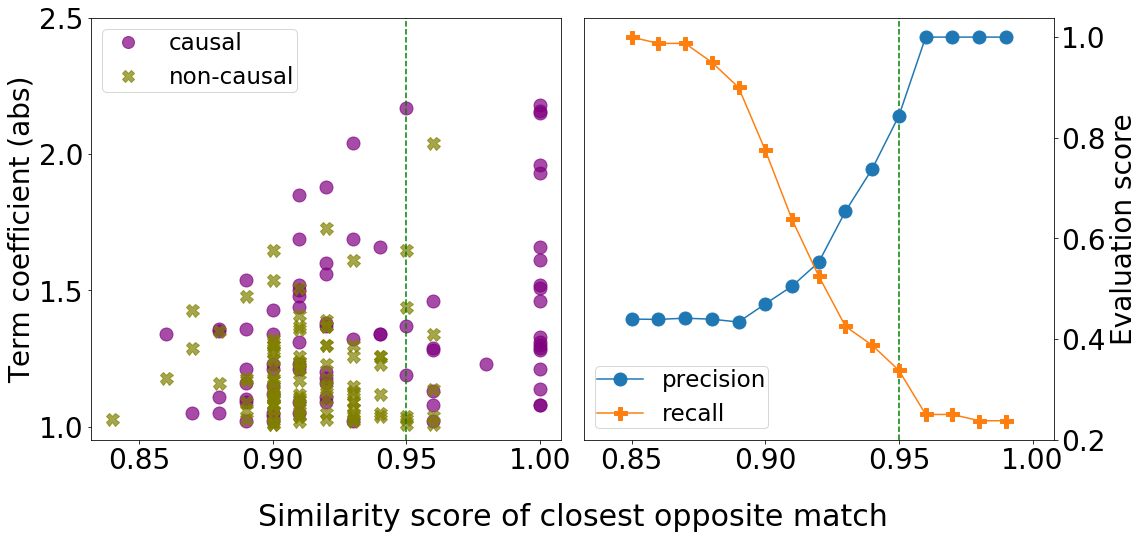

In [11]:
df_causal_max_imdb = run_experiment(moniker='IMDb', sort_by='coef')

Results for Kindle


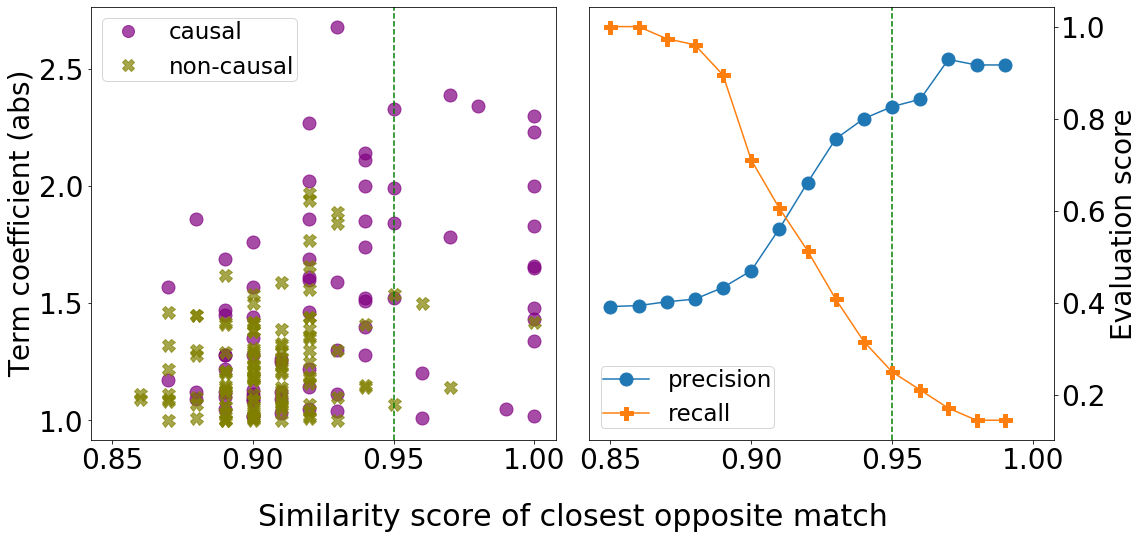

In [12]:
df_causal_max_kindle = run_experiment(moniker='Kindle', sort_by='coef')

- Example of word antonyms

In [37]:
df_imdb_vocab = pd.read_csv(data_path+'imdb_vocab_antonym_causal.csv')
df_imdb_vocab.shape, display(df_imdb_vocab.drop(labels=['Unnamed: 0'],axis=1).head())

,term,causal,coef,antonyms,antonym_source
0,great,1,2.166,"{'little': -0.289, 'worst': -2.915}",antonym
1,amazing,1,1.926,"{'unimpressive': -0.462, 'ugly': -0.681, 'ineffective': -1.062}",synonym_antonym
2,excellent,1,1.640,"{'inferior': -0.644, 'worst': -2.915, 'low': -0.399}",antonym
3,fantastic,1,1.638,"{'unimpressive': -0.462, 'inferior': -0.644}",antonym
4,wonderful,1,1.495,"{'unimpressive': -0.462, 'inferior': -0.644}",antonym


((2449, 6), None)

- Example of identified causal terms (IMDB)

In [13]:
thresh = 0.95
df_causal_max_imdb['identified_causal'] = df_causal_max_imdb['similarity'].apply(lambda x: 1 if x>thresh else 0)
Counter(df_causal_max_imdb[df_causal_max_imdb.identified_causal == 1].causal), display(df_causal_max_imdb.head()[['term','similarity','causal','identified_causal']])

,term,similarity,causal,identified_causal
0,addition,0.890,0,0
1,adorable,0.894,1,0
2,amazing,0.952,1,1
3,andy,0.900,0,0
4,anger,0.912,0,0


(Counter({1: 27, 0: 5}), None)

- Example of closest opposite match (kindle)

In [14]:
thresh = 0.95
df_causal_max_kindle['identified_causal'] = df_causal_max_kindle['similarity'].apply(lambda x: 1 if x>thresh else 0)

In [15]:
df_causal_max_kindle[df_causal_max_kindle.identified_causal == 1].iloc[5:10][['term','similarity','causal','identified_causal']]

,term,similarity,causal,identified_causal
42,disappointing,0.971,1,1
43,disappointment,0.992,1,1
53,enjoyed,0.955,1,1
55,entertaining,0.965,1,1
58,exciting,1.000,1,1


In [16]:
ds_data = pickle.load(open(data_path+'ds_kindle_emb.pkl','rb'))
df_data = ds_data.df
df_ite_match = pickle.load(open(data_path+'kindle_ite_match.pkl','rb'))
df_close_match = get_closest_match(df_ite_match)

In [17]:
df_close_match[(df_close_match.term == 'disappointment') & (df_close_match.similarity == 0.992)]

,term,sentence_id,label,match_id,match_label,similarity
1576,disappointment,5811,-1,369,1,0.992
1587,disappointment,9710,-1,2503,1,0.992


In [18]:
df_data.iloc[[5811,369]]

,text,rating,label,flag,i_th
5811,this short story was a disappointment,2,-1,selected_train,5811
369,This was a great short story,5,1,selected_train,369


In [19]:
df_data.iloc[[9710,2503]]

,text,rating,label,flag,i_th
9710,This read was a disappointment,2,-1,selected_train,9710
2503,This was a fun read,4,1,selected_train,2503
